In [ ]:
# to unzip the zipped filed in desired location
#!unzip "drive/My Drive/DogVision/dog-breed-identification.zip" -d "drive/My Drive/DogVision/"

# 🐶 End-to-end Multi-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.x and Tensorflow Hub. 

## 1. Problem
Idenify a image of a dog given an image of a dog.

## 2. Data
We are using the data from kaggle's dog breed identification competition. 

## 3. Evaluation
Evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features 
Some information about the data are :-
* We are dealing with images (unstructured data) so its probabily best we use deep learning/transfer learning.
* There are 120 different breeds of dog (this means there are 120 different classes)
* There are 10,000+ images in training sets. (these images have labels)
* There are around 10,000+ images in the test set. (these images will have no label because we will want to predict them)




# Get your workspace ready

* Import Tensorflow 2.x
* Import Tensorflow Hub
* Make sure we are using GPU

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
print('TF Version:',tf.__version__)
print('TF_Hub Version',hub.__version__)

# check for GPU availability
print('GPU is available') if tf.config.list_physical_devices('GPU') else print('GPU not available')

TF Version: 2.8.0
TF_Hub Version 0.12.0
GPU not available


# Getting our data ready (turning into Tensors)

with all machine learning models, our data has to be in numeric format. So thats what we will be doing first.Turning our images into Tensors (numeric representation)

Lets start by accessing our data and checking our labels.

In [6]:
# checkout labels of our data
import pandas as pd
labels_csv=pd.read_csv('labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<AxesSubplot:>

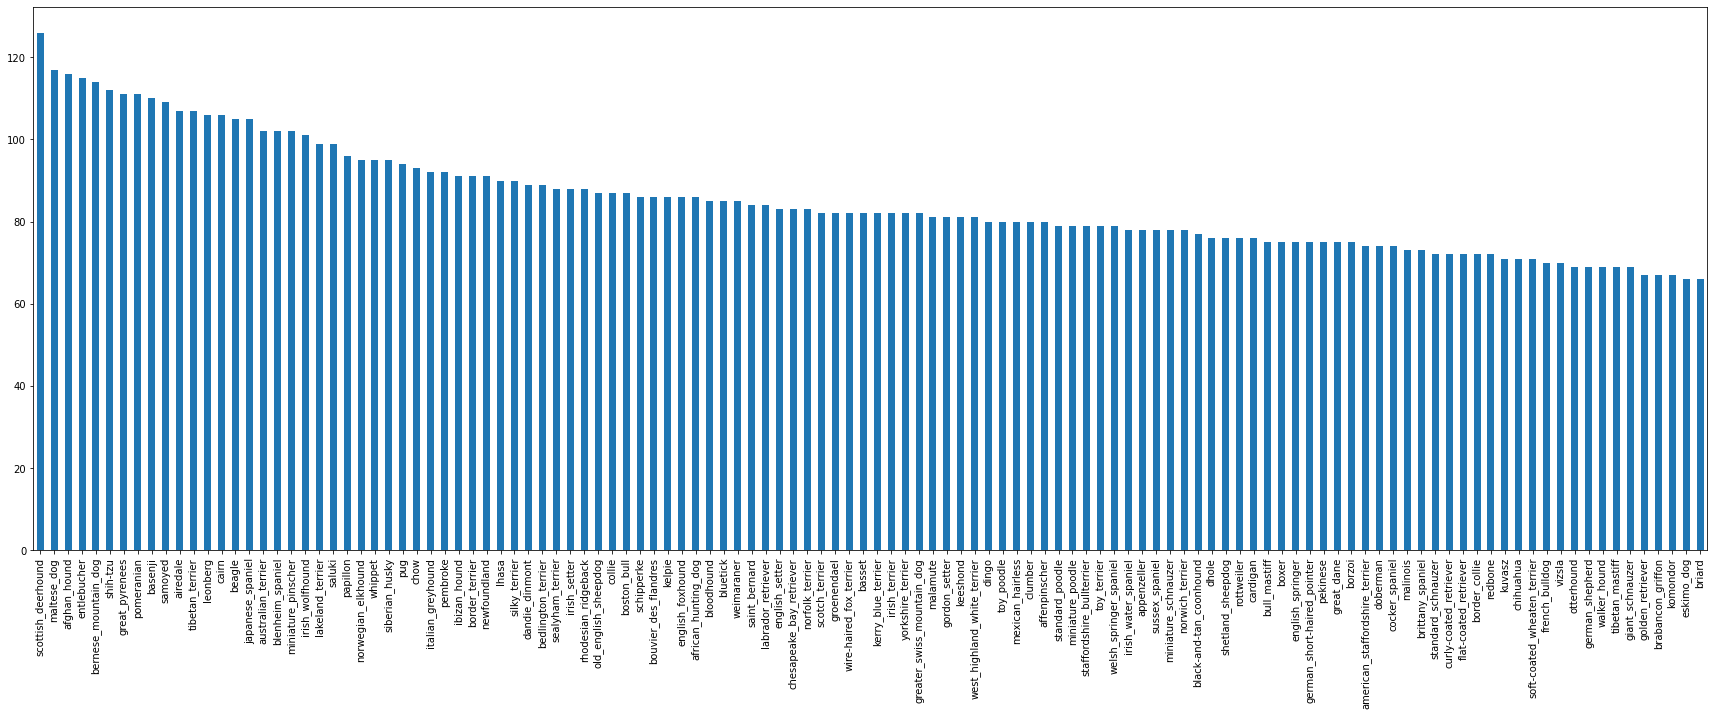

In [7]:
# how many images are there per class (breed)
labels_csv['breed'].value_counts().plot.bar(figsize=(30,10))

In [8]:
labels_csv['breed'].value_counts().median()

82.0

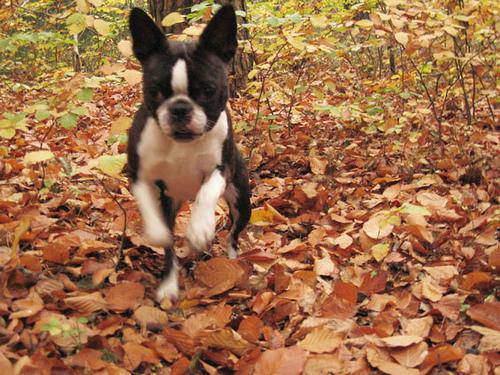

In [9]:
#Lets view an image
from IPython.display import Image
Image('train/000bec180eb18c7604dcecc8fe0dba07.jpg')

In [10]:
# create a pathnames for image ID's
filenames=['train/'+fname+'.jpg' for fname in labels_csv['id']]
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# check whether the number of filenames matches the number of actual images files
import os
if len(os.listdir('train/'))==len(filenames):
  print('File names matches the actual amount of files')
else:
  print('File names donot match the actual amount of files')  


File names matches the actual amount of files


 since we have now got our training image filepaths in a list ,lets prepare our labels

In [12]:
labels=labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
#see if number of labels matches the number of file names
if len(filenames)==len(labels):
  print('Number of labels matches the number of file names')
else:
  print('Number of labels does not matches the number of file names')  

Number of labels matches the number of file names


In [14]:
# find the unique label values
import numpy as np
unique_breeds=np.unique(labels)
len(unique_breeds)

120

In [15]:
# Turn the single labels into array of boolean
labels[0]==unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
#Turn every label into boolean arrays
boolean_labels=[label==unique_breeds for label in labels]

In [17]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [18]:
# Turning boolean array into integers
print(labels[0]) #original label
print(np.where(labels[0]==unique_breeds)) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) #there will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating our own validation set

since the dataset from kaggle doesnot come with the validation set we are going to create our own

In [19]:
#setup for x and y variables
x=filenames
y=boolean_labels

len(x),len(y)

(10222, 10222)

we are going to start of experimenting with ~1000 images and increase as needed

In [20]:
# set the number of images to use for experimentation
NUM_IMAGES=10000 # @param {type:'slider',min:1000,max:10000,step:100}


In [21]:
# lets split our data into training and validation set
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=42)

len(x_train),len(x_val),len(y_train),len(y_val)

(8000, 2000, 8000, 2000)

# Preprocessing Images (Turning Images into tensors)

To preprocess our images to tensor we're going to write a finctions which does a few things:-
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable,image
3. Turn our image(jpg) into tensor
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the image to be shape of (224,224)
6. Return the modified image 

In [22]:
# convert image to numpy array
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
%matplotlib inline

image=imread(filenames[0])
image.shape


(375, 500, 3)

In [23]:
image.max(),image.min()

(255, 0)

In [24]:
# we can turn it into tensor by using tf.constant
tf.constant(image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[108,  46,   0],
        [152,  92,  42],
        [180, 120,  70],
        ...,
        [176, 144,  69],
        [189, 157,  82],
        [214, 182, 107]],

       [[151,  93,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 136,  56],
        [172, 139,  60],
        [188, 157,  77]],

       [[151,  98,  56],
        [188, 137,  94],
        [162, 113,  70],
        ...,
        [200, 168,  81],
        [196, 162,  75],
        [200, 168,  81]],

       ...,

       [[189, 122,  69],
        [186, 119,  66],
        [183, 116,  63],
        ...,
        [213, 160, 106],
        [212, 159, 107],
        [209, 156, 102]],

       [[186, 119,  66],
        [184, 117,  64],
        [183, 116,  63],
        ...,
        [197, 145,  88],
        [199, 146,  92],
        [199, 147,  90]],

       [[182, 115,  62],
        [181, 114,  61],
        [183, 116,  63],
        ...,
        [184, 132,  7

Now we have seen what a image looks like in Tensor, lets make a function to preprocess them

In [25]:
#define size of image
IMG_SIZE=224

#create a function for preprocessing image
def process_image(file_path,img_size=IMG_SIZE):
  #read the image file
  image=tf.io.read_file(file_path) #reads and outputs the entire content of given filename

  # Turn the jpeg image into numeric Tensor with 3 color channel(Red,Green,Blue)
  image=tf.image.decode_jpeg(image,channels=3)

  #convert the color channel values from 0-255 to 0-1 values
  image=tf.image.convert_image_dtype(image,dtype=tf.float32)

  #resize  our image to our desired value (244,244)
  image=tf.image.resize(image,size=(img_size,img_size))

  return image




## Turning our data into batches

why turn our data into batches?
lets say you are trying to process 10,000+ images in one go... they all migh not fit into memory.

so we will do about 32 images at one time (you can manually adjust the batchsize if you need)

In order to use tensorflow effectively, we need our data in the form of tensor tuples which look like this:- `(image,label)`


In [26]:
# create a simple function to return a tuple (image,label)
def get_image_label(image_path,label):
  """ takes an image file path and the associated label,
  process the image and returns the tuple (image,label).
  """
  image=process_image(image_path)
  return image,label



Now we have got our way to turn our data into tuples in the form (image,labels)

, let's make a function to turn all our data x & y into batches 

In [27]:
# define the batch size, 32 is a good start
BATCH_SIZE=32

#create a function to turn data into batches
def create_data_batches(x,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  """
  creates batches of data out of image(x) and label(y) pairs
  Shuffles the data if its training data but doesn't shuffle if its validation data.
  Also accepts test data as inputs(no labels).
  """
  # if the data is test dataset we probably dont have any labels
  if test_data:
    print('Creating test data batches . . .')
    data=tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch=data.map(process_image).batch(batch_size)
    return data_batch

    #if the data is valid dataset then we dont need to shuffle it
  elif valid_data:
     print('Creating Valid data batches . . .')
     data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
     data_batch=data.map(get_image_label).batch(batch_size)
     return data_batch

    
  else:
      print('Creating train data batches . . .')
      #turn filepaths and labels into tensors
      data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
      data=data.shuffle(buffer_size=len(x))
      data_batch=data.map(get_image_label).batch(batch_size)
      return data_batch

In [28]:
#create training and validation data batch
train_data=create_data_batches(x_train,y_train)
valid_data=create_data_batches(x_val,y_val,valid_data=True)


Creating train data batches . . .
Creating Valid data batches . . .


In [29]:
# checkout the different attributes of our data batches
train_data.element_spec,valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches
our data are now in batches , however they can belittle hard to understand/comprehend. lets visualize them

In [30]:
import matplotlib.pyplot as plt

# create a function for viewing images in a data batch
def show_25_images(images,labels):
  '''
  displays the plot of 25 images and their labels from data batch
  '''
  #setup the figure
  plt.figure(figsize=(10,10))
  #loop through 25 (for displaying 25 images)
  for i in range(25):
    # create subplots 5 rows 5 columns
    ax=plt.subplot(5,5,i+1) #(row,column,index)
    #display an image
    plt.imshow(images[i])
    #display the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #turn the grid lines off
    plt.axis('off')

32 32


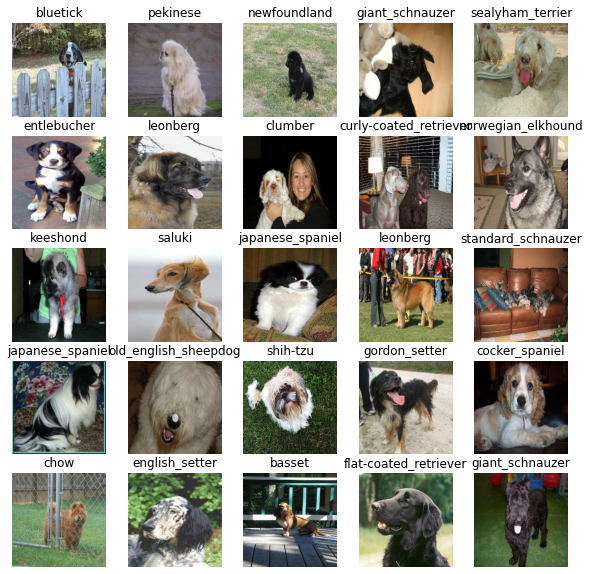

In [31]:
# now visualize the data in training batch
train_images,train_labels=next(train_data.as_numpy_iterator())
print(len(train_images),len(train_labels))
show_25_images(train_images,train_labels)

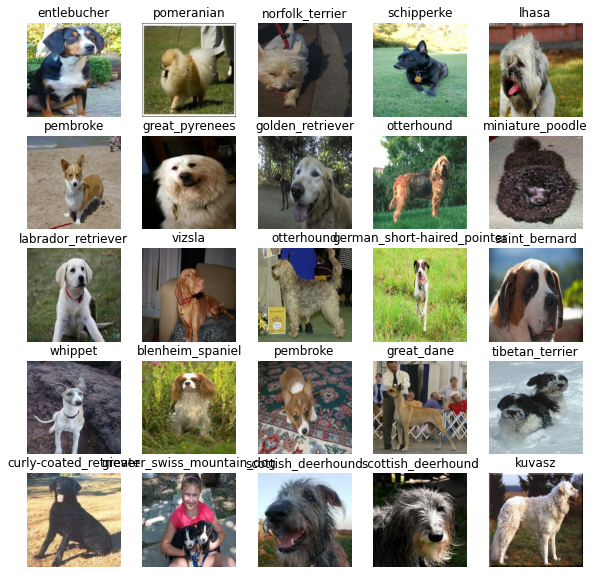

In [32]:
#lets visualize our validation 
valid_images,valid_labels=next(valid_data.as_numpy_iterator())
show_25_images(valid_images,valid_labels)

## Building a model
Before we build our model there are few things we need to define:-
* The input shape(our images shape, in the form of Tensors) to our model.
* The output shape(image labels,in the form of Tensors) of our model.
* The URL of the model we want to use.


In [33]:
# setup input shape to the model
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3] # batch height width color channels

#setup output shape of the models
OUTPUT_SHAPE=len(unique_breeds)

#setup model url from Tensorflow hub
MODEL_URL='https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4'

 Now we have our inputs , outputs and model ready to go. Let's put them together into a keras deep learning model

 Knowing this; let's create a function which:
 * Takes the input shape, output shape andmodel we have choosen as parameters
 * Defines the layers in keras model in sequential fashion
 * Compile the model (says it should be evaluated and improved)
 * Build the model (tell the model the input shape it will be getting)
 * Returns the model.

In [34]:
#create a function which builds a keras model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print('Building model with',model_url)

  #setup the model layers
  model=tf.keras.Sequential([hub.KerasLayer(model_url), #layer 1 (input layer)
                             tf.keras.layers.Dense(units=output_shape,
                                                   activation='softmax')]) # layer 2(output layer)

  #compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
                )
  
  #build the model
  model.build(input_shape)

  return model

In [31]:
model=create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4


KeyboardInterrupt: 

## Creating callbacks
Callbacks are helper functions, a model can use during training to do such things as save
its progress , check its progress or stop training early if a model stops improving 

We'll call two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model for training to long.


### TensorBoard Callback
To setup a TensorBoard Callback, we need to do three things:-
1. Load the tensorboard notebook extension
2. Create a Tensorboard callback which is able is save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our model training logs with the `%tensorboard` magic function (we will do this after model training)

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard


In [35]:
import datetime

#create a function to build a TensorBoard callback
def create_tensorboard_callback():
  #create a log directory for storing tensorboard logs
  logdir=os.path.join('DogVision/logs',
                      #make it so the logs gets tracked whenever we run an experiment
                      datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  
  return tf.keras.callbacks.TensorBoard(logdir)




### Early Stopping callback

Early stopping helps our model from overfitting by stopping training if a certain evaluation metrics stops improving

In [36]:
#create early stopping callback
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

## Training a model (on subset of data)
Our first model is only going to train 1000 images,to make sure everything is working

In [ ]:
NUM_EPOCHES=10 #@param {type:'slider' ,min:10,max:200,step:10}


Let's create a function that trains a model:-
* Create a model using `create_model()`
* Setup a tensorboard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data , number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use.
* Return the model



In [ ]:
# build a function to train and return a train model
def train_model():
  """
  Trains a model and returns the trained version
  """
  #create model
  model=create_model()

  # create new tensorboard session every time we train
  tensorboard=create_tensorboard_callback()

  # fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHES,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  
  # return fitted model
  return model




In [60]:
# fit the model to the data
model=train_model()


Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4
Epoch 1/10
250/250 [==============================] - 565s 2s/step - loss: 1.8893 - accuracy: 0.5604 - val_loss: 1.1128 - val_accuracy: 0.7055
Epoch 2/10
250/250 [==============================] - 566s 2s/step - loss: 0.6955 - accuracy: 0.7934 - val_loss: 1.1577 - val_accuracy: 0.7000
Epoch 3/10
250/250 [==============================] - 548s 2s/step - loss: 0.4492 - accuracy: 0.8577 - val_loss: 1.1774 - val_accuracy: 0.7095
Epoch 4/10
250/250 [==============================] - 533s 2s/step - loss: 0.3056 - accuracy: 0.9022 - val_loss: 1.2053 - val_accuracy: 0.7105
Epoch 5/10
250/250 [==============================] - 576s 2s/step - loss: 0.2137 - accuracy: 0.9349 - val_loss: 1.2255 - val_accuracy: 0.7110
Epoch 6/10
250/250 [==============================] - 538s 2s/step - loss: 0.1541 - accuracy: 0.9603 - val_loss: 1.2704 - val_accuracy: 0.7030
Epoch 7/10
250/250 [==============================] - 500s

### Checking the tensorflow logs
The tensorboard magic function (%tensorboard) will access the log directory we created earlier and visualize its contents

In [80]:
%tensorboard --logdir /DogVision/logs

## Making and Evaluating predictions using a trained model


In [38]:
prediction=model.predict(valid_data,verbose=1)
prediction


17/63 [=======>......................] - ETA: 1:30

KeyboardInterrupt: 

In [ ]:
prediction[100]

array([2.48327455e-13, 7.23491089e-09, 1.40129197e-09, 4.02291953e-05,
       1.12647190e-10, 2.10754038e-07, 2.58215440e-08, 1.26351212e-11,
       1.81247650e-09, 9.46038126e-12, 1.56974977e-09, 1.15767580e-06,
       4.36697922e-09, 1.28278677e-09, 1.71096310e-08, 4.22662488e-10,
       9.01673734e-03, 1.25951610e-10, 1.08077039e-03, 2.43211673e-08,
       2.97740610e-10, 1.39348663e-11, 1.92985506e-11, 3.02174819e-08,
       8.20766672e-08, 2.41285603e-10, 2.71171783e-11, 5.76059058e-08,
       9.63749898e-08, 1.34110861e-10, 3.50529240e-06, 1.34021745e-08,
       1.09216236e-09, 9.73025560e-01, 5.97675354e-10, 3.43627404e-10,
       1.14658922e-08, 5.25290852e-11, 2.75324368e-08, 1.86164051e-09,
       5.96266290e-08, 5.89242077e-08, 3.58851338e-10, 1.60203925e-07,
       5.78938682e-07, 1.94683747e-13, 3.98282332e-08, 2.36820208e-09,
       5.23914002e-11, 2.53924009e-05, 8.56424320e-10, 3.05573900e-09,
       5.01383852e-07, 1.51588186e-11, 2.59151079e-07, 1.63647455e-05,
      

In [ ]:
len(prediction)

2000

In [ ]:
prediction.shape

(2000, 120)

In [ ]:
np.sum(prediction[100])

1.0000001

In [ ]:
#First prediction
print(prediction[100])
print(f'max value (probability of predicction):{np.max(prediction[100])}')
print(f'Sum: {np.sum(prediction[100])}')
print(f'Max index:{np.argmax(prediction[100])}')
print(f'Predicted label:{unique_breeds[np.argmax(prediction[100])]}')


[2.48327455e-13 7.23491089e-09 1.40129197e-09 4.02291953e-05
 1.12647190e-10 2.10754038e-07 2.58215440e-08 1.26351212e-11
 1.81247650e-09 9.46038126e-12 1.56974977e-09 1.15767580e-06
 4.36697922e-09 1.28278677e-09 1.71096310e-08 4.22662488e-10
 9.01673734e-03 1.25951610e-10 1.08077039e-03 2.43211673e-08
 2.97740610e-10 1.39348663e-11 1.92985506e-11 3.02174819e-08
 8.20766672e-08 2.41285603e-10 2.71171783e-11 5.76059058e-08
 9.63749898e-08 1.34110861e-10 3.50529240e-06 1.34021745e-08
 1.09216236e-09 9.73025560e-01 5.97675354e-10 3.43627404e-10
 1.14658922e-08 5.25290852e-11 2.75324368e-08 1.86164051e-09
 5.96266290e-08 5.89242077e-08 3.58851338e-10 1.60203925e-07
 5.78938682e-07 1.94683747e-13 3.98282332e-08 2.36820208e-09
 5.23914002e-11 2.53924009e-05 8.56424320e-10 3.05573900e-09
 5.01383852e-07 1.51588186e-11 2.59151079e-07 1.63647455e-05
 2.09089297e-08 1.66144400e-06 6.40899001e-10 6.70329062e-03
 3.10935877e-09 4.71264240e-04 1.65153278e-08 9.94071456e-08
 1.55827066e-13 1.143012

It wouldbe great if we could see the image, the prediction is being made on:

**Note** prediction probabilities are also called confidenc labels


In [ ]:
# Turn theprediction probabilities into their repective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turn the array of predictionprobabilities into labels
  """
  return unique_breeds[np.argmax(prediction_probabilities)]


# get the predicted label based on an array of prediction probabilities
pred_label=get_pred_label(prediction[9])
pred_label

NameError: name 'prediction' is not defined

since our validation data is still in batch dataset, we will have to unbachify it to mae predictions on the validation images and compare those predictions to the validation labels(truth labels) 

In [ ]:
# create a function unbatch a batch data set
def unbachify(data):
  images_=[]
  labels_=[]

  for image,label in data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_breeds[np.argmax(label)])

  return images_,labels_

val_images,val_labels=unbachify(valid_data)

val_images,val_labels

([array([[[0.96884924, 0.9701885 , 0.6773138 ],
          [0.9649684 , 0.9649684 , 0.6752449 ],
          [0.97255224, 0.97255224, 0.6897149 ],
          ...,
          [0.94544876, 0.93533266, 0.63851905],
          [0.9122807 , 0.90027964, 0.59165734],
          [0.6266023 , 0.6167168 , 0.30141547]],
  
         [[0.9636907 , 0.9677085 , 0.69290984],
          [0.97148985, 0.97514886, 0.7090773 ],
          [0.9998248 , 0.99992114, 0.74782914],
          ...,
          [0.97280353, 0.9686894 , 0.715118  ],
          [0.9849285 , 0.99132735, 0.7000457 ],
          [0.8505023 , 0.8618907 , 0.55982476]],
  
         [[0.94763345, 0.9589167 , 0.70516145],
          [0.96966976, 0.9795524 , 0.73575866],
          [0.9953722 , 0.99858195, 0.7804973 ],
          ...,
          [0.8728771 , 0.8872267 , 0.69398195],
          [0.8451019 , 0.8824005 , 0.6274633 ],
          [0.7930096 , 0.83910555, 0.5551244 ]],
  
         ...,
  
         [[0.47171637, 0.37899917, 0.3959688 ],
          [0.2

In [ ]:
# lets make a function to visualize all these values

def plot_pred(pred_probabilities,images,labels,n=1):
  """
  view prediction,ground truth and image for sample n
  """
  pred_prob,true_label,image=pred_probabilities[n],labels[n],images[n]

  #get predict label
  pred_label=get_pred_label(pred_prob)

  # Change the color of title depending on prediction is right or wrong:
  if true_label==pred_label:
     color='Green'
  else:
     color='Red'  


  # plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # change the plot title to be predicted , probability of prediction and truth label
  plt.title('{} {:2.0f}% {}'.format(pred_label,np.max(pred_prob)*100,true_label),color=color)



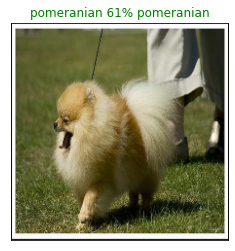

In [ ]:
plot_pred(pred_probabilities=prediction,labels=val_labels,images=val_images)


now we have onemodel to visualize our  model top prediction, lets make another to view our models top 10 predictions.

This function will:
* Take an of input of prediction probabilities array and a ground truth array and an integer.
* Find the prediction using `get_pred_label()`
* Find the top 10 :
  * Prediction probabilities index
  * Prediction  probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels,coloring the true label green  

In [ ]:
def plot_pred_conf(prediction_probabilities,labels,n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n
  """
  pred_prob,true_label=prediction_probabilities[n],labels[n]

  # get the predicted label
  pred_label=get_pred_label(pred_prob)

  #Find the top 10 predictionconfidence indexes
  top_10_pred_indexes=pred_prob.argsort()[-10:][::-1]

  #Find the top 10 prediction confidence values
  top_10_pred_values=pred_prob[top_10_pred_indexes]

  #Find top 10 prediction labels
  top_10_pred_labels=unique_breeds[top_10_pred_indexes]

  #setup plot
  top_plot=plt.bar(np.arange(len(top_10_pred_labels)),top_10_pred_values,color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),labels=top_10_pred_labels,rotation='vertical')

  #Change the color if true label
  if np.isin(true_label,top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels==true_label)].set_color('green')
  else:
    pass
  

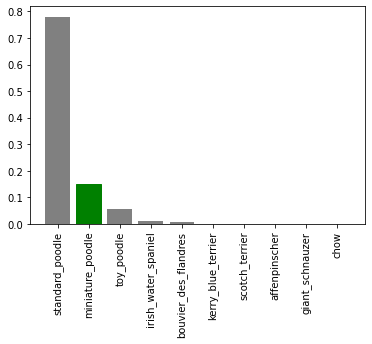

In [ ]:
plot_pred_conf(prediction_probabilities=prediction,labels=val_labels,n=9)

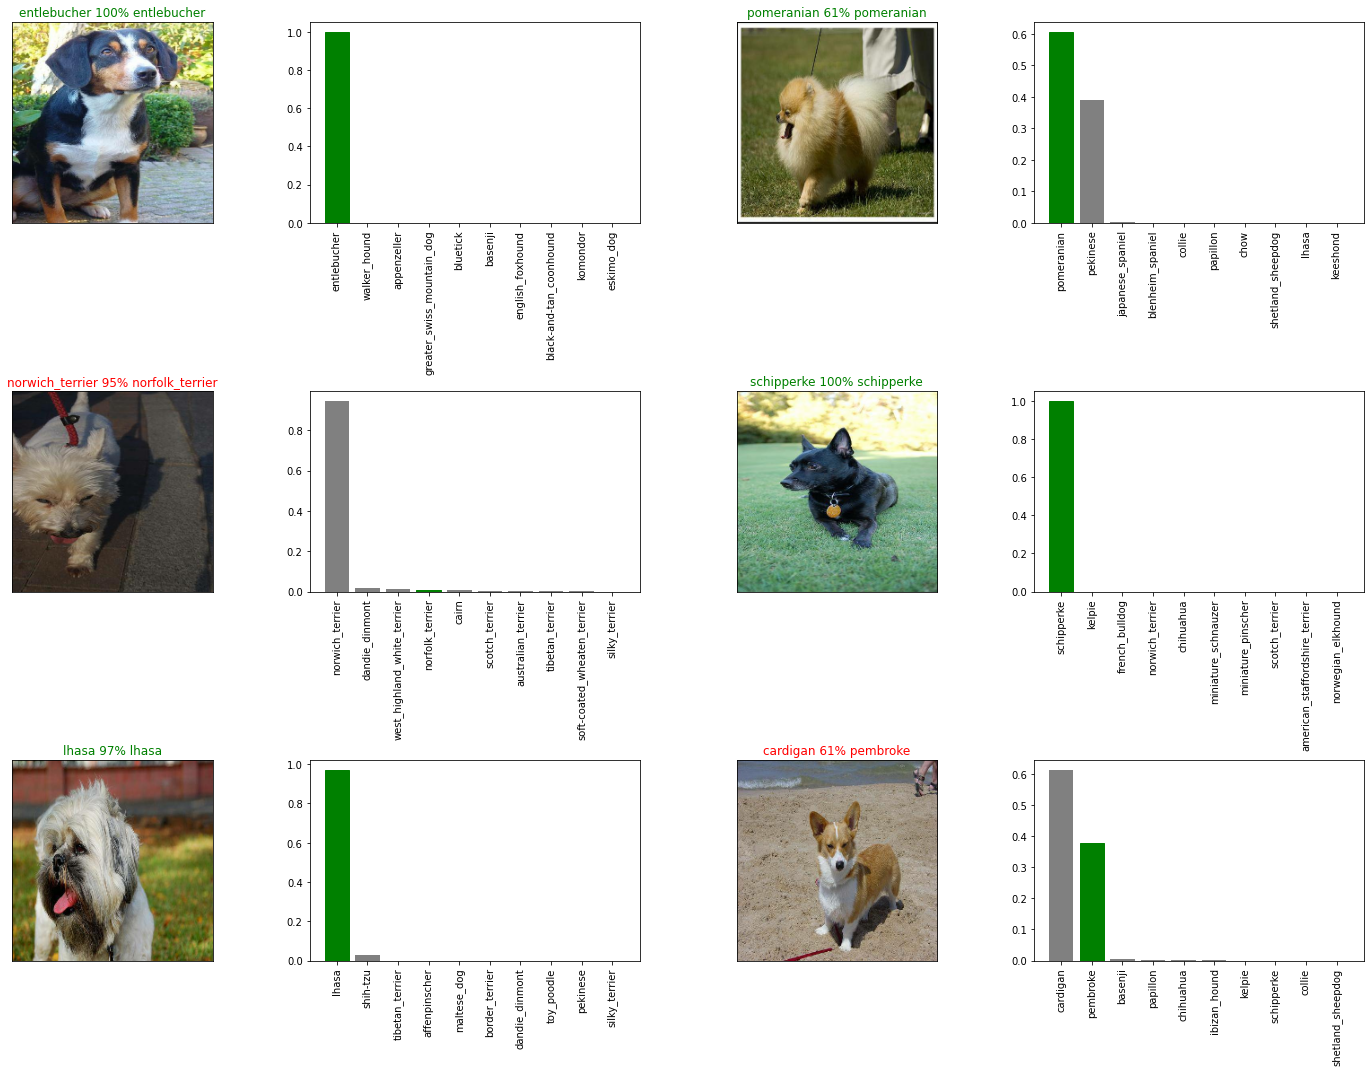

In [ ]:
# Lets check out the few predictions and their different values
i_multiplier=0
num_rows=3
num_cols=2
num_images=num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows,2*num_cols,2*i+1)
  plot_pred(pred_probabilities=prediction,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier
            )
  plt.subplot(num_rows,2*num_cols,2*i+2)
  plot_pred_conf(prediction_probabilities=prediction,
            labels=val_labels,
            n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

  

# Saving and Reloading the trained model

In [81]:
# create a finction to save a model
def save_model(model,suffix=None):
  """
  save a given model in model directory and append a suffix (string)
  """

  #create a model directory pathname with current time
  modeldir=os.path.join('DogVision/models',datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path=modeldir+'-'+suffix+'.h5' # save format of model
  model.save(model_path)
  return model_path



In [35]:
# create a function to load a trained model
def load_model(model_path):
  """
  Loads the saved model from specified path
  """
  print(f'Loading saved model from {model_path}')
  model=tf.keras.models.load_model(model_path,
                                   custom_objects={'KerasLayer':hub.KerasLayer})
  return model
  

In [83]:
#save our model
save_model(model,suffix='images-Adam')


'DogVision/models/20220212-20001644675319-images-Adam.h5'

In [36]:
loaded_full_model=load_model('DogVision/models/20220212-20001644675319-images-Adam.h5')

Loading saved model from DogVision/models/20220212-20001644675319-images-Adam.h5


KeyboardInterrupt: 

In [ ]:
# get custom image file path
import os
custom_path='DogVision/my_dog_images/'
custom_image_path=[custom_path+fname for fname in os.listdir(custom_path)]
custom_image_path

['DogVision/my_dog_images/0a0b97441050bba8e733506de4655ea1.jpg',
 'DogVision/my_dog_images/0a0f82d4557f70718efa26f8a8a7773f.jpg']

In [ ]:
# Turn our custom images into batch datasets

custom_data=create_data_batches(custom_image_path,test_data=True)


Creating test data batches . . .


In [111]:
#making predictions on custom data
custom_preds=loaded_full_model.predict(custom_data)

In [112]:
# get custom image prediction label
custom_pred_labels=[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

custom_pred_labels

['black-and-tan_coonhound', 'cairn']

In [113]:
#get custom images
custom_images=[]
#loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)



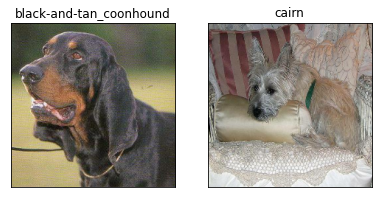

In [114]:
#check custom image predictions
plt.figure(figsize=(10,10))
for i,image in enumerate(custom_images):
  plt.subplot(1,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

In [39]:
import pickle

model = pickle.load(open('model','rb'))


In [40]:
# Turn our custom images into batch datasets

custom_data=create_data_batches(['DogVision/my_dog_images/0a0f82d4557f70718efa26f8a8a7773f.jpg'],test_data=True)

Creating test data batches . . .


In [41]:
custom_preds=model.predict(custom_data)

In [42]:
custom_preds

array([[1.66739284e-07, 3.19541869e-08, 2.27852112e-07, 9.04181591e-12,
        3.12078242e-07, 4.27933432e-13, 1.20284358e-06, 1.94922439e-10,
        2.01128914e-12, 1.34580053e-12, 2.80790191e-09, 1.17355561e-11,
        2.31733740e-13, 2.98069078e-12, 8.57333649e-11, 3.42636308e-10,
        3.08835184e-12, 1.93867123e-07, 2.44602210e-14, 1.42809107e-11,
        1.02113392e-12, 1.57122468e-10, 2.28402844e-12, 6.71045836e-06,
        3.76480294e-14, 3.44739265e-10, 9.99023914e-01, 2.13233804e-08,
        3.35765134e-13, 3.95260216e-08, 1.31664016e-12, 1.94285130e-10,
        2.16087478e-12, 6.08303826e-14, 1.15209344e-11, 1.16947514e-04,
        3.04244685e-10, 5.72342063e-10, 4.39110526e-13, 1.32518866e-12,
        1.86799423e-10, 2.95124412e-13, 1.31337953e-12, 2.74251385e-11,
        3.50459516e-13, 3.56608992e-10, 1.80650428e-09, 9.11759646e-09,
        4.19271684e-09, 3.81706906e-12, 5.87704635e-13, 1.09505525e-08,
        8.23986192e-12, 8.95469032e-10, 3.74549003e-12, 1.071858

In [43]:
# get custom image prediction label
custom_pred_labels=[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

custom_pred_labels[0]

'cairn'

In [51]:
import wikipedia

details_dog = wikipedia.summary(f'dog {custom_pred_labels[0]}')
details_dog.replace("\n"," ")

"The Cairn Terrier is a terrier breed originating in the Scottish Highlands and recognized as one of Scotland's earliest working dogs. The breed was given the name Cairn because the breed's function was to hunt and chase quarry between the cairns in the Scottish highlands. Although the breed had existed long before, the name Cairn Terrier was a compromise suggestion after the breed originally was brought to official shows in the United Kingdom in 1909 under the name Short-haired Skye terriers. This name was not acceptable to The Kennel Club due to opposition from Skye Terrier breeders, and the name Cairn Terrier was suggested as an alternative.  "